In [1]:
start = "2010-01-01"
end   = "2018-06-01"

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

import yfinance as yf

sp500 = yf.download("^GSPC", start=start, end=end, progress=False)['Close']
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.loc[start_dt:end_dt]


C:\Users\cameronA\AppData\Local\Temp\ipykernel_29780\2580452301.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=start, end=end, progress=False)['Close']


C:\Users\cameronA\AppData\Local\Temp\ipykernel_29780\2625702193.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  thirty_day_return = sp500.rolling(30).apply(lambda x: x[-1] / x[0] - 1, raw=False).dropna()


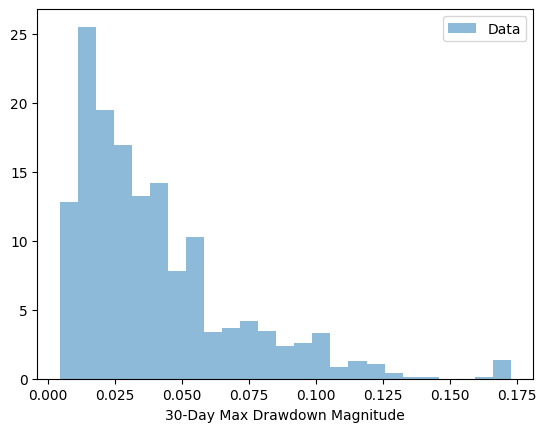

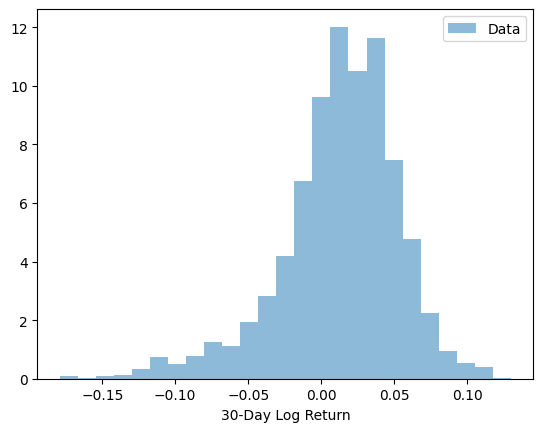

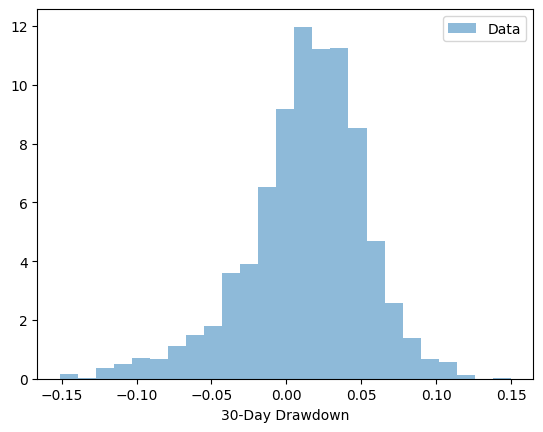

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# sp500 is your price series: pd.Series indexed by date

# --- compute daily log returns ---
log_ret = np.log(sp500 / sp500.shift(1)).dropna()
thirty_day_return = sp500.rolling(30).apply(lambda x: x[-1] / x[0] - 1, raw=False).dropna()


# --- resample by day ---
log_ret = log_ret.resample("1D").last().dropna()

# --- rolling 30-day max drawdown ---
def max_drawdown(log_returns_window):
    cum = log_returns_window.cumsum().apply(np.exp)
    running_max = cum.cummax()
    dd = cum / running_max - 1
    return dd.min()

window = 30
mdd_series = log_ret.rolling(window).apply(max_drawdown, raw=False).dropna()
ret_series = log_ret.rolling(window).sum().dropna()

# positive magnitudes
mdd_mag = -mdd_series.values

plt.hist(mdd_mag, bins=25, density=True, alpha=0.5, label="Data")
plt.xlabel("30-Day Max Drawdown Magnitude")
plt.legend()
plt.show()

plt.hist(ret_series.values, bins=25, density=True, alpha=0.5, label="Data")
plt.xlabel("30-Day Log Return")
plt.legend()
plt.show()

plt.hist(thirty_day_return.values, bins=25, density=True, alpha=0.5, label="Data")
plt.xlabel("30-Day Drawdown")
plt.legend()
plt.show()

In [3]:
import numpy as np
import pandas as pd

# bins in decimal
bins = np.array([
    -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 
    0, 1, 2, 3, 4, 5, 10, 15
]) / 100.0

# midpoints
midpoints = (bins[:-1] + bins[1:]) / 2

# ensure 1D
r = np.ravel(thirty_day_return)

# bin index for each return
bin_idx = pd.cut(r, bins=bins, labels=False, right=True, include_lowest=True)

# midpoint-mapped values
r_midpoint = midpoints[bin_idx]

# proportions (population share per midpoint)
proportions = pd.Series(r_midpoint).value_counts(normalize=True).sort_index()

print(proportions)


-0.175    0.000479
-0.125    0.016284
-0.075    0.054119
-0.025    0.237069
 0.005    0.106801
 0.015    0.118295
 0.025    0.117337
 0.035    0.111590
 0.045    0.090996
 0.075    0.137931
 0.125    0.009100
Name: proportion, dtype: float64


Short Put Delta: -0.41839184391103135
Long Put Delta: -0.09445760802784753


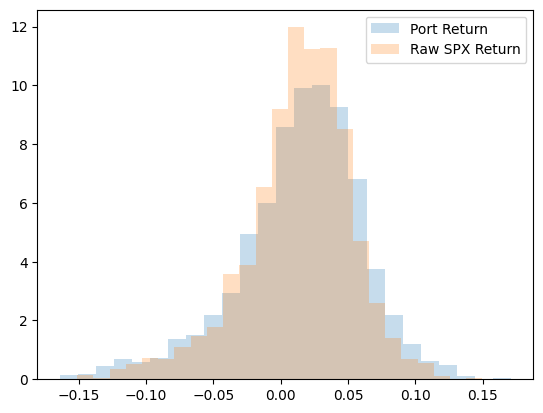

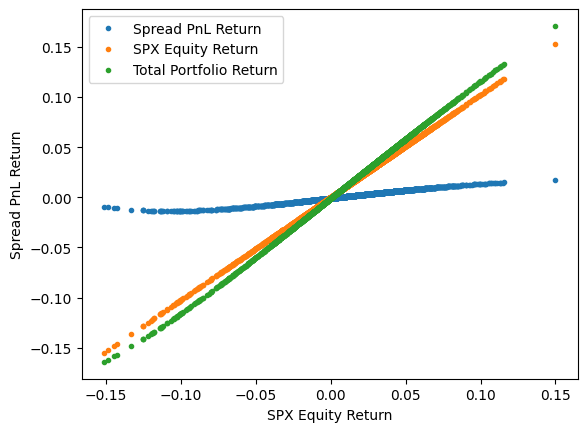

In [8]:
current_price = 100
short_strike = 98
long_strike = 82

short_position = -1
long_position = 3

implied_vol = 0.30

risk_free_rate = 0.0

ttm = 105/365
exit_ttm = ttm - 30/365

price_ranges = thirty_day_return.values

def black_scholes_value(S, K, T, r, sigma, position):
    from scipy.stats import norm
    from numpy import log, sqrt, exp

    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    call_price = S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    put_price = K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return position * put_price

def black_scholes_put_delta(S, K, T, r, sigma):
    from scipy.stats import norm
    from numpy import log, sqrt, exp

    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    return norm.cdf(d1) - 1.0    # put delta
print("Short Put Delta:", black_scholes_put_delta(current_price, short_strike, ttm, risk_free_rate, implied_vol))
print("Long Put Delta:", black_scholes_put_delta(current_price, long_strike, ttm, risk_free_rate, implied_vol))

portfolio_value = 1_000_000
num_contracts = 7500
spread_cost = num_contracts * (
    black_scholes_value(current_price, short_strike, ttm, risk_free_rate, implied_vol, short_position) +
    black_scholes_value(current_price, long_strike, ttm, risk_free_rate, implied_vol, long_position)
)

spread_values_at_exit = []
for price_change in price_ranges:
    exit_price = current_price * (1 + price_change)
    spread_value = (
        black_scholes_value(exit_price, short_strike, exit_ttm, risk_free_rate, implied_vol, short_position) +
        black_scholes_value(exit_price, long_strike, exit_ttm, risk_free_rate, implied_vol, long_position)
    ) * num_contracts
    spread_values_at_exit.append(spread_value)

spread_pnl = np.array(spread_values_at_exit) - spread_cost

spx_inv = portfolio_value - spread_cost 
spx_eqty = (1+price_ranges) * spx_inv



plt.hist((spx_eqty - spx_inv+ spread_pnl) / portfolio_value, bins=25, density=True, alpha=0.25, label="Port Return")
plt.hist((price_ranges), bins=25, density=True, alpha=0.25, label="Raw SPX Return")
plt.legend()
plt.show()

plt.plot( price_ranges, (spread_pnl) / portfolio_value, marker='.', linestyle='none',label="Spread PnL Return")
plt.plot(price_ranges , (spx_eqty -spx_inv) / portfolio_value, marker='.', linestyle='none', label="SPX Equity Return")
plt.plot(price_ranges , (spx_eqty -spx_inv) / portfolio_value +(spread_pnl) / portfolio_value, marker='.', linestyle='none', label="Total Portfolio Return")
plt.xlabel("SPX Equity Return")
plt.ylabel("Spread PnL Return")
plt.legend()
plt.show()